In [1]:
import sys
import os

import functions
from functions import*
import matplotlib.colors as colors


### State Parameters

In [2]:
#I increased the cutoff to check everything is ok
boson_dim = 10
lower_fock = 0
upper_fock = 4

one_logical = 2

#Bases
# logical_plus = np.sin((N * np.pi)/(F + 2*N - F % N)) * fock(boson_dim, 0+shift)

logical_0 = (tensor(fock(boson_dim, lower_fock),fock(boson_dim,upper_fock))/np.sqrt(2) +tensor(fock(boson_dim, upper_fock),fock(boson_dim,lower_fock))/np.sqrt(2))

logical_1 = tensor(fock(boson_dim, one_logical),fock(boson_dim,one_logical))

logical_plus = (logical_0 + logical_1).unit()
logical_minus = (logical_0 - logical_1).unit()

logical_0 = logical_0.unit()
logical_1 = logical_1.unit()

Quantum object: dims = [[10, 10], [1, 1]], shape = (100, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


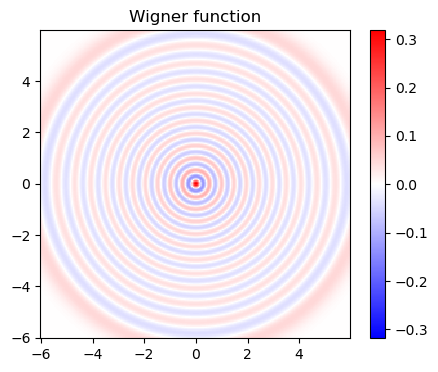

In [3]:

plt.figure(figsize=(5,4))

xvec = np.arange(-6, 6, 10.0 / 200)
yvec = xvec

X, Y = np.meshgrid(xvec, yvec)
state = logical_1
print(state)

W = wigner(state,xvec,yvec)

norm = colors.CenteredNorm(vcenter=0)

plt.pcolormesh(X, Y, W, cmap = 'bwr',  norm=norm)
plt.colorbar();
plt.title('Wigner function')
plt.show()


### Stabilisers

In [4]:
#Operators

n_operator = num(boson_dim)
a = destroy(boson_dim)
ln_Z = 1j * 2* np.pi * n_operator / 2 #(upper_fock-lower_fock)
Z_L = ln_Z.expm()

ancilla_plus = (basis(2, 0) + basis(2, 1)).unit()
ancilla_minus = (basis(2, 0) - basis(2, 1)).unit()

ln_Z_mode1 = tensor(Z_L, identity(boson_dim))

ln_Z_mode2 = tensor(identity(boson_dim), Z_L)

# S_l = fock(cutoff, 0)*fock(cutoff, N).dag()
# for i in range(1, cutoff-N):
#     S_l += fock(cutoff, i) * fock(cutoff, i+N).dag()

#Just checking
print(expect(ln_Z_mode2, logical_plus))
print(expect(ln_Z_mode2, logical_minus))

print(expect(ln_Z_mode2, logical_0))

print(expect(ln_Z_mode2, logical_1))



coupled_Z_mode1 = tensor(sigmay(), 0.985*ln_Z_mode1).expm()
coupled_Z_mode2 = tensor(sigmay(), 0.985*ln_Z_mode2).expm()

coupled_Z_mode1 = tensor(sigmay(), 0.5*ln_Z_mode1).expm()
coupled_Z_mode2 = tensor(sigmay(), 0.5*ln_Z_mode2).expm()

coupled_Z_mode1 = tensor(sigmay(), 1/2*ln_Z_mode1).expm()
coupled_Z_mode2 = tensor(sigmay(), 1/2*ln_Z_mode2).expm()



0.9999999999999997
0.9999999999999997
0.9999999999999998
1.0


In [5]:
def stab_rounds(state, n_rounds, corrector1,corrector2):
    for i in range(n_rounds):
        state = tensor(ket2dm(basis(2, 0)), state)
        psi_new = ( corrector2 * corrector1) * state * (corrector2 * corrector1).dag()
        psi_new = psi_new / psi_new.tr()
        psi_new = psi_new.ptrace([1,2])

        state = psi_new

    return state

def logical_decay(initial_state, time_steps, delta_t, heating_rate, rounds_per_correction,disp_kick):

    psi0 = initial_state

    psi = ket2dm(psi0)
    fidelity_array = [fidelity(psi,psi0)**2]

    
    for x in range(1, time_steps+1):
        
       
        if x % 100 == 0:
             print(x) 
        
        H = 0* tensor(identity(boson_dim),a.dag() *a) + 0* tensor(a.dag() *a,identity(boson_dim))

        times = np.linspace(0.0, delta_t, 200)
        result = mesolve(H, psi, times, [np.sqrt(heating_rate) * tensor(a,identity(boson_dim)), 
                                        np.sqrt(heating_rate) * tensor(a.dag(),identity(boson_dim)),
                                        np.sqrt(18)* tensor(a.dag()* a,identity(boson_dim)) + np.sqrt(18)* tensor(identity(boson_dim),a.dag()* a),
                                        np.sqrt(heating_rate) * tensor(identity(boson_dim),a),
                                        np.sqrt(heating_rate) * tensor(identity(boson_dim),a.dag())])

        psi = result.states[-1]
    
        if x % rounds_per_correction  == 0:
            
            psi = stab_rounds(psi, 1, coupled_Z_mode1, coupled_Z_mode2)   

        if x % rounds_per_correction == 0:
            alpha = np.random.normal(0, disp_kick) *np.exp( 1.j * np.random.uniform(0, 2*np.pi))
            beta = np.random.normal(0, disp_kick) *np.exp( 1.j * np.random.uniform(0, 2*np.pi))

            D1 = tensor(identity(boson_dim),displace(boson_dim, alpha))
            D2 = tensor(displace(boson_dim, beta),identity(boson_dim))
            
            
            psi = 1/2 *(D1 * psi * D1.dag() + D2 * psi * D2.dag())


            
        fidelity_array.append(fidelity(psi0, psi)**2)

    time_array = delta_t * np.linspace(0,1*time_steps,time_steps+1)
    return fidelity_array, time_array, psi
        

rounds_per_correction = 7
heating_rate = 0.2 #Hz

# time step
delta_t = 10e-3

initial_state = logical_plus
time_steps = 1000
disp_kick = 0.033

fidelity_array_corrected, time_array_corrected, psi_corrected = logical_decay(initial_state, time_steps, delta_t, heating_rate, rounds_per_correction,disp_kick)

fidelity_array_uncorrected, time_array_uncorrected, psi_uncorrected = logical_decay(initial_state, time_steps, delta_t, heating_rate, rounds_per_correction*1000, disp_kick)


100
200
300
400
500
600
700
800
900
1000
100
200
300
400
500
600
700
800
900
1000


(-0.1, 1.1)

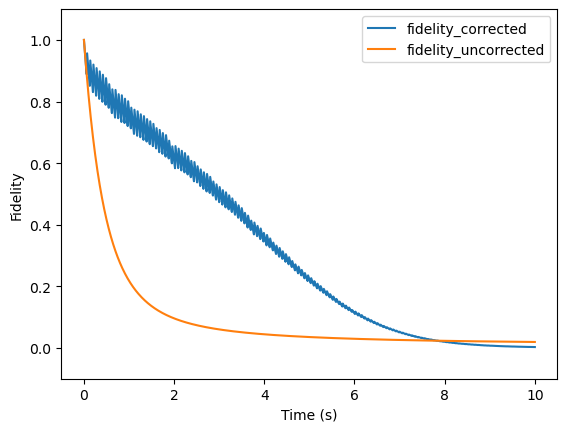

In [6]:
# plt.plot(S_l_array,label = 's_l')
plt.plot(time_array_corrected,fidelity_array_corrected,label = 'fidelity_corrected')
plt.plot(time_array_uncorrected,fidelity_array_uncorrected,label = 'fidelity_uncorrected')

plt.xlabel('Time (s)')
plt.ylabel('Fidelity')

plt.legend()
plt.ylim([-0.1,1.1])
# plt.xlim([-0.1,10.1])


Final purity with correction:  0.6949293679985037
Final purity without correction:  0.01319391966422209
Final phonon expectation value with correction:  (0.3406743619161002+0j)
1.0000000000000127
[[ 8.29806736e-01+0.00000000e+00j  2.91154330e-03+9.89681834e-03j
  -4.93352505e-05+3.42356167e-05j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 2.91154330e-03-9.89681834e-03j  1.67203998e-02+0.00000000e+00j
  -1.18838716e-04-3.66451904e-04j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [-4.93352505e-05-3.42356167e-05j -1.18838716e-04+3.66451904e-04j
   3.94107663e-02+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 ...
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   1.23435797e-20-6.29237027e-21j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00

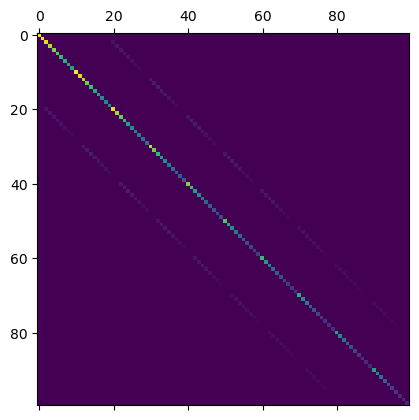

In [21]:
print("Final purity with correction: ", (psi_corrected**2).tr())
print("Final purity without correction: ", (psi_uncorrected**2).tr())
print("Final phonon expectation value with correction: ", expect(tensor(n_operator, identity(boson_dim)) + tensor(identity(boson_dim), n_operator), psi_corrected))
print(psi_corrected.tr())
print(psi_corrected.full()[0:20][0:20])

plt.matshow(np.real(psi_uncorrected))

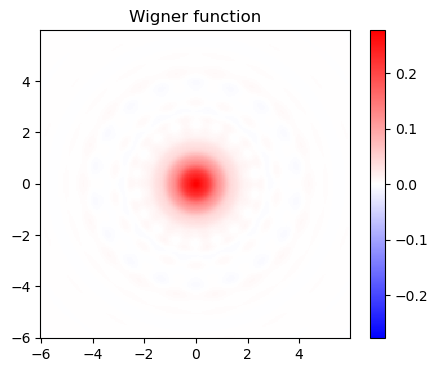

In [25]:

plt.figure(figsize=(5,4))

xvec = np.arange(-6, 6, 10.0 / 200)
yvec = xvec

X, Y = np.meshgrid(xvec, yvec)

diss_state = psi_corrected

W = wigner(diss_state,xvec,yvec)

norm = colors.CenteredNorm( vcenter=0)

plt.pcolormesh(X, Y, W, cmap = 'bwr',  norm=norm)
plt.colorbar();
plt.title('Wigner function')
plt.show()